## model

In [1]:
from model_v2 import sampling, membrane, fit, fitlog
import numpy as np

## data

In [2]:
import pandas as pd
def read_data(filename, corr1=None, corr2=None):

    df = pd.read_csv(filename, header=None)   #comma-delimited, corrected spectroscopy data
    df = df.rename(columns={0:'sample', 1:'cc'})    
    if corr1: df['cc'] += corr1
    if corr2: df['cc'] *= corr2
   
    
    try:
        #apical volume is 0.24 mL
        apical_amount = (df.loc[df['sample'] == 'AP', 'cc'].iloc[0]) * 0.25
    except:
        apical_amount = 0

    # Keep only rows where `samples` can be converted to integers
    df = df[pd.to_numeric(df['sample'], errors='coerce').notna()]
    df['sample'] = df['sample'].astype(int)

    #drop first two samples
    df = df.loc[df['sample'] > 2, ['sample','cc']].reset_index(drop=True)

    #convert cc [uM] to amount [nmol], volume is 1.2 mL
    df['amount'] = df['cc']*1.2
    return(df, apical_amount)

# transwell fits

In [5]:
def flatlog(x, x0=1e-3):
    x = np.asarray(x)
    return np.log(np.maximum(x, x0))

def score(output, target):
    N=min(len(output), len(target))
    return np.sum( (flatlog(output[:N]) - flatlog(target[:]))**2 )

def score2(output, target):
    return output

def constrain(p):
    return any(i < 1e-6 for i in p)

def constrain2(p):
    return any(i < 1e-5 or i > .9 for i in p)


In [6]:
def apply_sampling_fit(df, kon, koff, q, method='BFGS'):
    """Apply sampling fit and populate shared DataFrame fields."""
    samples = df['amount'].to_numpy()
    r = fit(sampling, samples, score, list(samples), constrain=constrain,
            pfix={"kon": kon, "koff": koff, "q": q}, method=method )
    df['I'] = pd.Series(r["params"])
    df['sim'] = pd.Series(r["output"])
    df['drop'] = pd.Series([x[0] for x in r["hidden"]])
    df['adsorb'] = pd.Series([x[1] for x in r["hidden"]])
    return r, df

def apply_membrane_fit(df):
    r=fit(membrane, df['I'].to_numpy(), score, {"c_A0":0.1, "P0":.05}, 
          constrain=constrain, method="Nelder-Mead")
    df['model'] = pd.Series(r["output"])
    return r, df

def make_result(df, r, extra_keys=[]):
    result = {
        "df": df,
        "output": r["error"],
        "model_params": r["params"]
    }
    for key in extra_keys:
        if key in r:
            result[key] = r[key]
    return result

def single(kon, koff, q, df):
    _, df = apply_sampling_fit(df, kon, koff, q)
    r, df = apply_membrane_fit(df)
    return make_result(df, r)

def apply_calib_fit(kon, koff, q, df):
    samples = df['amount'].to_numpy()
    
    def sampling2(I0,x0=(0,0),kon=0.1, koff=0.1,q=0.1):
        input = np.concatenate([I0, np.zeros(len(samples)-1)])
        return( 
            sampling(input, kon=kon*0.6, koff=koff*0.6, q=q*0.6) )
            
        
    r = fit(sampling2, samples, score, [samples[0]/(1-q)], constrain=constrain,
            pfix={"kon": kon, "koff": koff, "q": q})
    df['I'] = pd.Series(
                np.concatenate([r["params"], np.zeros(len(samples)-1)]))
    df['sim'] = pd.Series(r["output"])
    df['drop'] = pd.Series([x[0] for x in r["hidden"]])
    df['adsorb'] = pd.Series([x[1] for x in r["hidden"]])
    df['model'] = df['I']
    return r, df

def calib(kon,koff,q,df):
    r,df = apply_calib_fit(kon,koff,q,df)
    return make_result(df, r)

def multi(kon, koff, q, dfs):
    ret = {"error":0, "errors":[], "params":[]}
    ret_dfs=[]
    
    for i,df in enumerate(dfs):
        if i > 0:
            r, df = apply_sampling_fit(df, kon, koff, q)         
            r, df = apply_membrane_fit(df)
        else:
            r, df = apply_calib_fit(kon, koff, q, df)
            r["error"] /= 1
        ret["error"] += r["error"]
        ret["errors"].append(r["error"])
        ret_dfs.append(df)
        ret["params"].append(r["params"])
        
    return make_result(ret_dfs, ret, extra_keys=["errors"])

In [7]:
import matplotlib.pyplot as plt
def plot(df,ymin=5e-4,ymax=.3):

    cols = ['amount', 'I', 'sim', 'drop', 'adsorb', 'model']

    df.plot(x = 'sample', 
        y = cols, 
        style = ['o','o','-','-','-','-'],
        grid = True)
    plt.legend(['measured','deconv','sim','droplets','immobil','fit'])
    plt.yscale('log')
    plt.ylim(ymin, ymax)
    plt.show()

## transwell 1

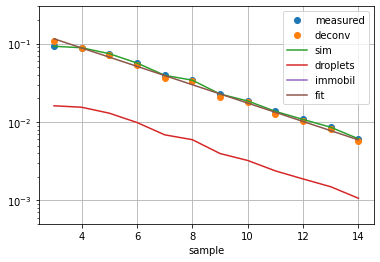

{'df':     sample        cc    amount         I       sim      drop        adsorb  \
 0        3  0.077291  0.092749  0.108858  0.092749  0.016109  1.102708e-07   
 1        4  0.073977  0.088772  0.088082  0.088772  0.015418  1.724643e-07   
 2        5  0.062090  0.074508  0.072031  0.074508  0.012941  1.932493e-07   
 3        6  0.047206  0.056647  0.053545  0.056647  0.009839  1.846285e-07   
 4        7  0.032871  0.039445  0.036458  0.039445  0.006851  1.589450e-07   
 5        8  0.028484  0.034181  0.033266  0.034181  0.005937  1.370991e-07   
 6        9  0.018958  0.022750  0.020764  0.022750  0.003951  1.102506e-07   
 7       10  0.015460  0.018552  0.017823  0.018552  0.003222  8.896599e-08   
 8       11  0.011379  0.013655  0.012804  0.013655  0.002372  7.022639e-08   
 9       12  0.008974  0.010769  0.010268  0.010769  0.001870  5.542243e-08   
 10      13  0.007138  0.008566  0.008183  0.008566  0.001488  4.381873e-08   
 11      14  0.005085  0.006102  0.005674  0.0

In [7]:
df1,ap1=read_data('../chlq-240705-tw.csv')
p0={
    "kon":0.16,
    "koff": 0.3,
    "q": 0.2
}
q=fit(single, 0, score2, p0, constrain=constrain, pfix={'df':df1}, logfile="/tmp/fitlog", method='Nelder-Mead')
plot(q["df"])
q

## transwell 2

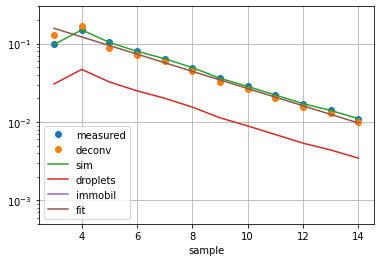

{'df':     sample        cc    amount         I       sim      drop    adsorb  \
 0        3  0.081454  0.097745  0.128304  0.097745  0.030557  0.000002   
 1        4  0.125233  0.150280  0.166706  0.150280  0.046980  0.000005   
 2        5  0.086479  0.103775  0.089238  0.103775  0.032442  0.000006   
 3        6  0.066576  0.079891  0.072426  0.079891  0.024976  0.000008   
 4        7  0.053603  0.064324  0.059458  0.064324  0.020109  0.000009   
 5        8  0.041261  0.049513  0.044884  0.049513  0.015479  0.000009   
 6        9  0.030111  0.036133  0.031951  0.036133  0.011296  0.000010   
 7       10  0.023703  0.028444  0.026040  0.028444  0.008892  0.000010   
 8       11  0.018424  0.022109  0.020129  0.022109  0.006912  0.000010   
 9       12  0.014286  0.017143  0.015591  0.017143  0.005359  0.000010   
 10      13  0.011681  0.014017  0.013040  0.014017  0.004382  0.000010   
 11      14  0.009199  0.011039  0.010108  0.011039  0.003451  0.000010   
 
        model  
 

In [8]:
df2,ap2=read_data('../chlq-240919-tw.csv')
p0={
    "kon":1e-5,
    "koff": 0.4,
    "q": 0.15
}
q=fit(single, 0, score2, p0, constrain=constrain, pfix={'df':df2}, logfile="/tmp/fitlog", method='Nelder-Mead')
plot(q["df"])
q

## transwell 3

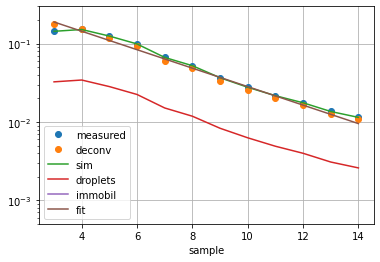

{'df':     sample        cc    amount         I       sim      drop        adsorb  \
 0        3  0.119958  0.143950  0.176513  0.143950  0.032561  1.766095e-06   
 1        4  0.126558  0.151870  0.153662  0.151870  0.034353  2.556897e-06   
 2        5  0.104332  0.125198  0.119165  0.125198  0.028320  2.540259e-06   
 3        6  0.082707  0.099248  0.093378  0.099248  0.022450  2.215348e-06   
 4        7  0.055615  0.066738  0.059384  0.066738  0.015096  1.688874e-06   
 5        8  0.043633  0.052360  0.049107  0.052360  0.011844  1.305696e-06   
 6        9  0.030616  0.036739  0.033206  0.036739  0.008310  9.635584e-07   
 7       10  0.023127  0.027752  0.025719  0.027752  0.006278  7.189266e-07   
 8       11  0.018044  0.021653  0.020273  0.021653  0.004898  5.480126e-07   
 9       12  0.014665  0.017598  0.016681  0.017598  0.003981  4.311386e-07   
 10      13  0.011342  0.013610  0.012708  0.013610  0.003079  3.363132e-07   
 11      14  0.009537  0.011444  0.010954  0.0

In [31]:
df3,ap3=read_data('../chlq-240918-tw.csv')
p0={
    "kon":.1,
    "koff": 0.4,
    "q": 0.15
}
q=fit(single, 0, score2, p0, constrain=constrain, pfix={'df':df3}, logfile="/tmp/fitlog", method='Nelder-Mead')
plot(q["df"])
q

## calib

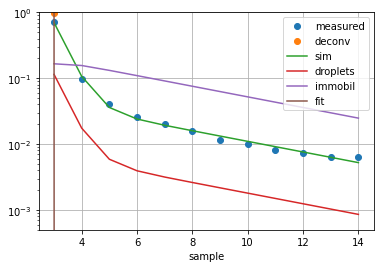

{'df':     sample        cc    amount         I       sim      drop    adsorb  \
 0        3  0.603485  0.724182  0.979065  0.698965  0.114422  0.165677   
 1        4  0.081036  0.097243  0.000000  0.106650  0.017459  0.155991   
 2        5  0.033690  0.040428  0.000000  0.035967  0.005888  0.131595   
 3        6  0.021824  0.026189  0.000000  0.024031  0.003934  0.109519   
 4        7  0.016713  0.020056  0.000000  0.019309  0.003161  0.090982   
 5        8  0.013303  0.015964  0.000000  0.015965  0.002613  0.075565   
 6        9  0.009537  0.011444  0.000000  0.013251  0.002169  0.062758   
 7       10  0.008336  0.010003  0.000000  0.011004  0.001801  0.052122   
 8       11  0.006877  0.008252  0.000000  0.009139  0.001496  0.043288   
 9       12  0.006167  0.007400  0.000000  0.007590  0.001243  0.035951   
 10      13  0.005234  0.006281  0.000000  0.006304  0.001032  0.029858   
 11      14  0.005271  0.006325  0.000000  0.005235  0.000857  0.024798   
 
        model  
 

In [8]:
dfc,_ = read_data('../chlq-240924-calib.csv')
p0 = {
    "kon":.1,
    "koff": 0.3,
    "q": 0.1
}
q = fit(calib, 0, score2, p0, constrain=constrain, pfix={'df':dfc}, logfile="/tmp/fitlog", 
        method='Nelder-Mead')
plot(q["df"], ymax=1)
q

## joint fit

In [9]:
df2,ap2=read_data('../chlq-240919-tw.csv')
df3,ap3=read_data('../chlq-240918-tw.csv')

p0={
    "kon":.2,
    "koff": 0.25,
    "q": 0.22
}
q=fit(multi, 0, score2, p0, constrain=constrain2, pfix={'dfs':[dfc, df1, df2, df3]}, logfile="/tmp/fitlog", method='Nelder-Mead')
q

{'df': [    sample        cc    amount         I       sim      drop    adsorb  \
  0        3  0.603485  0.724182  1.149427  0.850883  0.141308  0.157236   
  1        4  0.081036  0.097243  0.000000  0.123735  0.020549  0.154260   
  2        5  0.033690  0.040428  0.000000  0.033979  0.005643  0.135187   
  3        6  0.021824  0.026189  0.000000  0.020624  0.003425  0.116781   
  4        7  0.016713  0.020056  0.000000  0.016743  0.002781  0.100683   
  5        8  0.013303  0.015964  0.000000  0.014307  0.002376  0.086780   
  6        9  0.009537  0.011444  0.000000  0.012316  0.002045  0.074794   
  7       10  0.008336  0.010003  0.000000  0.010614  0.001763  0.064463   
  8       11  0.006877  0.008252  0.000000  0.009147  0.001519  0.055560   
  9       12  0.006167  0.007400  0.000000  0.007884  0.001309  0.047885   
  10      13  0.005234  0.006281  0.000000  0.006795  0.001128  0.041271   
  11      14  0.005271  0.006325  0.000000  0.005856  0.000973  0.035571   
  
   

==============================

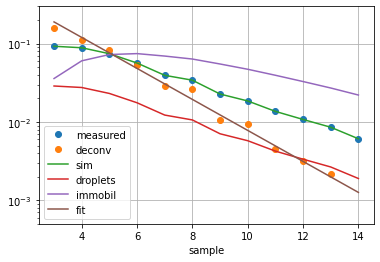

{'df':     sample        cc    amount         I       sim      drop    adsorb  \
 0        3  0.077291  0.092749  0.157459  0.092749  0.028809  0.035901   
 1        4  0.073977  0.088772  0.112062  0.088772  0.027574  0.060425   
 2        5  0.062090  0.074508  0.082361  0.074508  0.023143  0.072709   
 3        6  0.047206  0.056647  0.053104  0.056647  0.017596  0.074713   
 4        7  0.032871  0.039445  0.028899  0.039445  0.012252  0.069510   
 5        8  0.028484  0.034181  0.026730  0.034181  0.010617  0.063695   
 6        9  0.018958  0.022750  0.010552  0.022750  0.007066  0.055048   
 7       10  0.015460  0.018552  0.009346  0.018552  0.005763  0.047146   
 8       11  0.011379  0.013655  0.004501  0.013655  0.004241  0.039513   
 9       12  0.008974  0.010769  0.003214  0.010769  0.003345  0.032855   
 10      13  0.007138  0.008566  0.002194  0.008566  0.002661  0.027168   
 11      14  0.005085  0.006102  0.000255  0.006102  0.001895  0.022086   
 
        model  
 

In [11]:
df1,ap1=read_data('../chlq-240705-tw.csv')
r1=single(kon=0.228, koff=0.274, q=0.237, df=df1)
plot(r1["df"])
r1

In [39]:
r1["df"].to_csv('chlq-240705-tw-fit.csv', index=False, float_format="%.3e" )

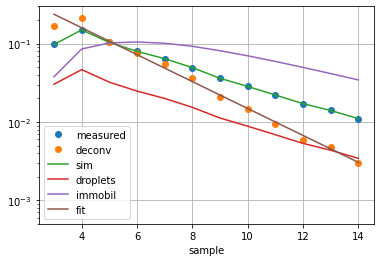

In [12]:
df2,ap2=read_data('../chlq-240919-tw.csv')
r2=single(kon=0.228, koff=0.274, q=0.237, df=df2)
plot(r2["df"])
r2
r2["df"].to_csv('chlq-240919-tw-fit.csv', index=False, float_format="%.3e" )

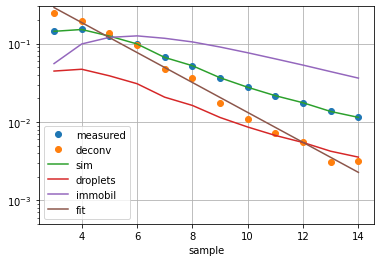

In [13]:
df3,ap3=read_data('../chlq-240918-tw.csv')
r3=single(kon=0.228, koff=0.274, q=0.237, df=df3)
plot(r3["df"])
r3
r3["df"].to_csv('chlq-240918-tw-fit.csv', index=False, float_format="%.3e" )

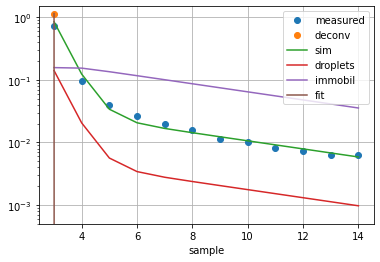

In [16]:
dfc,_ = read_data('../chlq-240924-calib.csv')
rc=calib(kon=0.228, koff=0.274, q=0.237, df=dfc)
plot(rc["df"], ymax=1.5)
rc
rc["df"].to_csv('chlq-240924-calib-fit.csv', index=False, float_format="%.3e" )